Number of events detected: 44
Skipping event 0 due to error: object of type 'NoneType' has no len()
Skipping event 1 due to error: object of type 'NoneType' has no len()
Skipping event 2 due to error: object of type 'NoneType' has no len()
Skipping event 5 due to error: could not broadcast input array from shape (14,) into shape (0,)
Skipping event 9 due to error: could not broadcast input array from shape (31,) into shape (0,)
Skipping event 13 due to error: could not broadcast input array from shape (69,) into shape (0,)
Skipping event 15 due to error: could not broadcast input array from shape (71,) into shape (0,)
Skipping event 17 due to error: could not broadcast input array from shape (75,) into shape (0,)
Skipping event 20 due to error: could not broadcast input array from shape (96,) into shape (0,)
Skipping event 21 due to error: negative dimensions are not allowed
Skipping event 27 due to error: could not broadcast input array from shape (136,) into shape (0,)
Skipping event

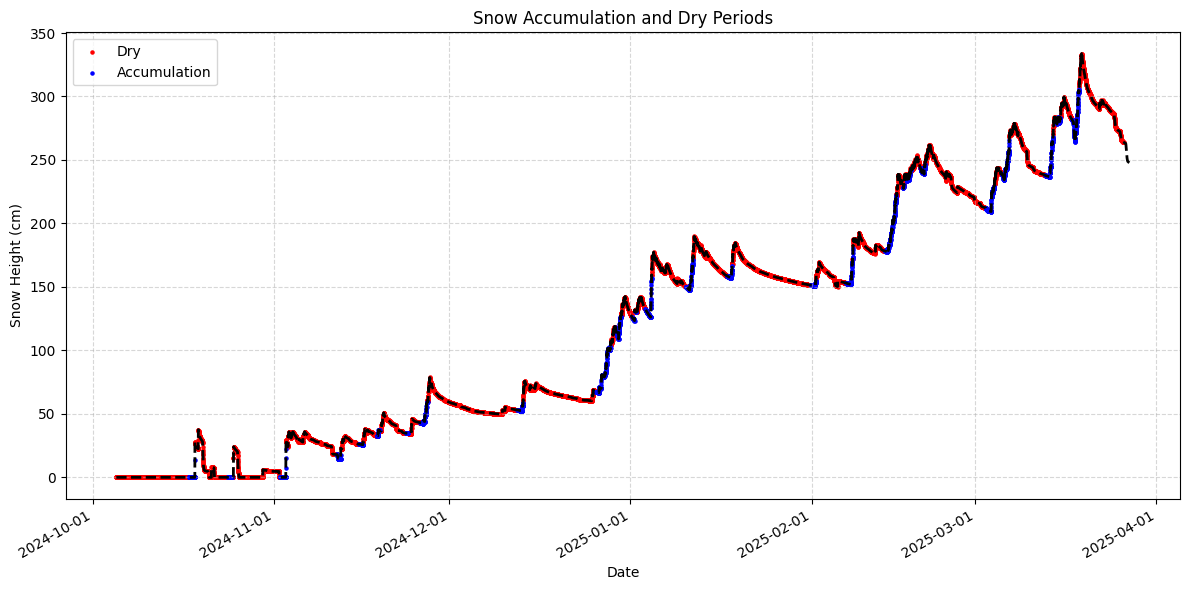

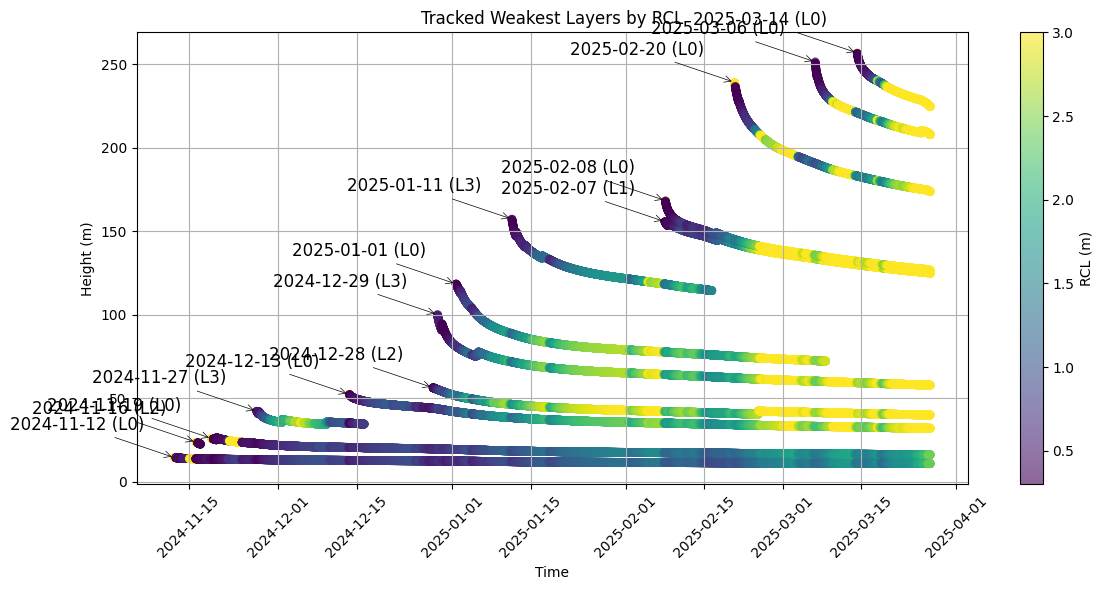

In [ ]:
# main.py
# Main script to load profile, compute HST, identify accumulation periods, and plot weak layers

from config import PRO_FILE
from data_loader import load_profile, extract_variables
from utils import compute_hst, extract_weak_layers_by_event, identify_accumulation_periods, identify_accumulation_periods_old, track_layers,get_number_events, track_all_layers_xr,parse_gtype
from plotting import plot_hst_and_periods, plot_seasonal_sn38, plot_weak_layers_by_event, plot_grain_type_with_weak_layers
import matplotlib.pyplot as plt
import numpy as np
import pickle

#load profile data
pro = load_profile(PRO_FILE)

# Extract variables from the profile
# This function should return a dictionary with keys like 'ht', 'dates', 'id',
# 'rcl', 'gt', 'rho', 'sn38', etc.
vars = extract_variables(pro)

# Compute the historical snow height (HST)
hst = compute_hst(vars['ht'])


# Identify accumulation and dry periods
# Note: You can use either the new or old method for identifying accumulation periods.
dry_indices, accum_indices = identify_accumulation_periods_old(hst)
#labels = identify_accumulation_periods(hst)
#accum_indices = np.where(labels == 1)[0]
#dry_indices = np.where(labels == 0)[0]

# Plot the historical snow height and accumulation/dry periods
plot_hst_and_periods(vars['dates'], hst, dry_indices, accum_indices)

# Extract the dates for dry and accumulation periods
num_events, accum_end_index =get_number_events(accum_indices)
print(f"Number of events detected: {num_events}")

#Track all layers from one event
#DEPRECATED: This function is now replaced by track_all_layers_xr
#ds = track_layers(accum_indices, accum_end_index, 0, vars['id'], vars['rcl'], vars['gt'], vars['rho'], vars['sn38'], vars['ht'], vars['dates'])

#Track all layers for accumulation events periods
ds_accum = track_all_layers_xr(accum_indices, accum_end_index, vars['id'], vars['rcl'], vars['gt'], vars['rho'], vars['sn38'],vars['shear_strength'], vars['ht'], vars['dates'])

# Save ds_accum to a file (e.g., using pickle)
#with open('ds_accum.pkl', 'wb') as f:
#    pickle.dump(ds_accum, f)

#Extract the weak layers by event
#weak_layers_dry = extract_weak_layers_by_event(ds_dry)
weak_layers_accum  = extract_weak_layers_by_event(ds_accum)

# Save weak_layers_accum to a file (e.g., using pickle)
with open('weak_layers_accum.pkl', 'wb') as f:
    pickle.dump(weak_layers_accum, f)

#Plot the weak layers for the entire season
plot_weak_layers_by_event(weak_layers_accum, ds_accum, fig_name='accum_Layers_CCL_layer.png')





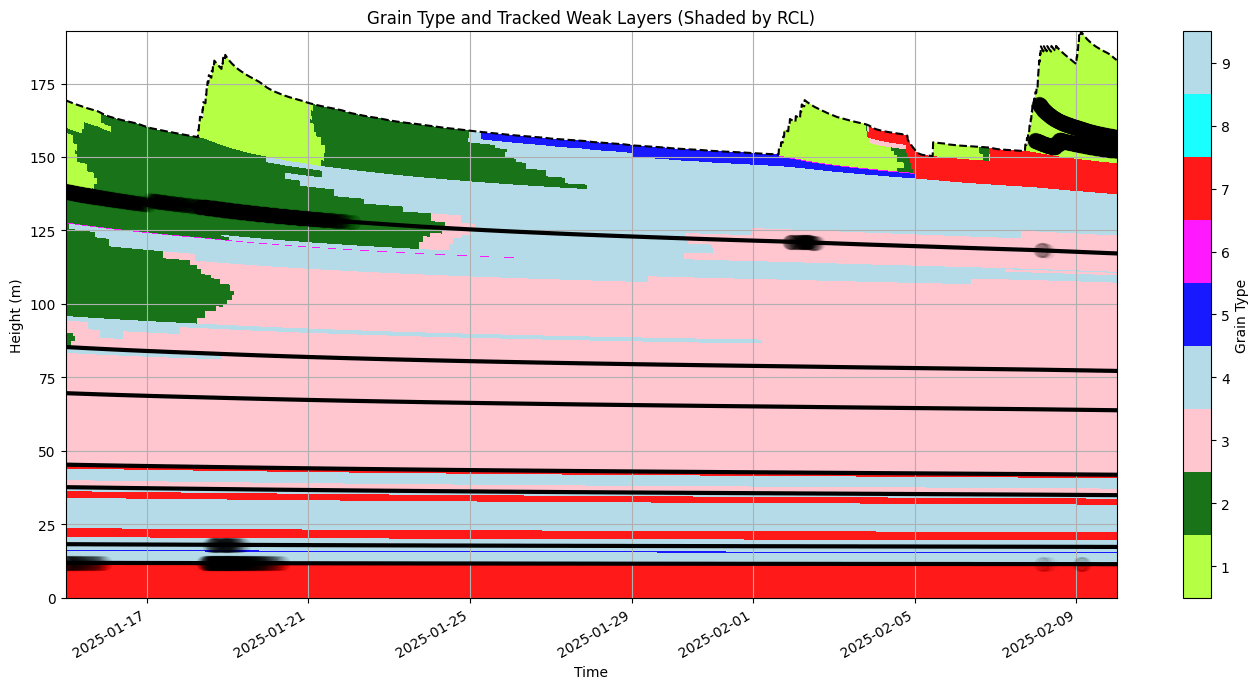

In [42]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates, matplotlib.colors as mcolors
from utils import parse_gtype
#plot the seasonal weak layers 
#plot_grain_type_with_weak_layers(vars, weak_layers_accum)
# Focused zoom example from January 15 to February 10
plot_grain_type_with_weak_layers_2(
    vars,
    weak_layers_accum,
    start_date='2025-01-15',
    end_date='2025-02-10',
    fig_name='weak_layers_jan_feb.png'
)

In [ ]:

def plot_grain_type_with_weak_layers_2(
    vars,
    weak_layers_by_event,
    fig_name='grain_and_weak_layers.png',
    start_date=None,
    end_date=None
):
    """
    Plot grain type pcolormesh with overlaid weak layers shaded by RCL.

    Parameters:
    - vars: dict with keys 'dates', 'ht', 'gt'
    - weak_layers_by_event: dict of weak layer tracking info
    - fig_name: filename to save the figure
    - start_date, end_date: optional datetime64-like bounds
    """

    # --- Normalize dates ---
    all_dates = np.array(vars['dates'], dtype='datetime64[ns]')
    hst = np.array(vars['ht'], dtype=object)
    Z = np.array(vars['gt'], dtype=object)

    # Convert start/end dates to datetime64
    if start_date is not None:
        start_date = np.datetime64(start_date, 'ns')
    else:
        start_date = all_dates[0]

    if end_date is not None:
        end_date = np.datetime64(end_date, 'ns')
    else:
        end_date = all_dates[-1]

    # Filter date window
    mask = (all_dates >= start_date) & (all_dates <= end_date)
    datetime = all_dates[mask]
    hst = hst[mask]
    Z = Z[mask]

    if len(datetime) == 0:
        raise ValueError("No data in selected date window.")

    deltat = datetime[1] - datetime[0]

    # Grain type colormap
    cgt = ['greenyellow', 'darkgreen', 'pink', 'lightblue', 'blue', 'magenta', 'red', 'cyan', 'lightblue']
    cmap_gt = mcolors.ListedColormap(cgt)
    vmin = 0.5
    vmax = len(cmap_gt.colors) + 0.5

    fig, ax = plt.subplots(figsize=(14, 7))

    # --- Plot grain type pcolormesh ---
    for cnt, dt in enumerate(datetime):
        if cnt >= len(hst) or cnt >= len(Z):
            continue

        heights = hst[cnt]
        values,_,_ = parse_gtype(Z[cnt])

        if len(heights) < 2 or len(values) != len(heights) - 1:
            continue

        x_edges = [dt, dt + deltat]
        y_edges = heights

        X, Y = np.meshgrid(x_edges, y_edges)
        C = np.array(values).reshape(len(y_edges) - 1, 1)

        try:
            cb = ax.pcolormesh(X, Y, C, cmap=cmap_gt, vmin=vmin, vmax=vmax, shading='flat', alpha=0.9)
        except Exception as e:
            print(f"Error at time index {cnt}: {e}")
            continue

    # --- Overlay weak layers ---
    for event, data in weak_layers_by_event.items():
        time = np.array(data["time"], dtype='datetime64[ns]')
        rcl = np.array(data["rcl"])
        ht = np.array(data["ht"])
        #gt = np.array(data["gt"]) #Do we need to output grain type of the weak layer in the IDer?
        # might need a sub routine to get the weakest grain of the weak layer - possible IDer for summary grain type
        layer_idx = data["layer_idx"]

        # Filter to current time window
        time_mask = (time >= start_date) & (time <= end_date)
        if not np.any(time_mask):
            continue

        rcl_clean = np.where(rcl >= 0, rcl, np.nan)
        ht_clean = np.where(np.isnan(rcl_clean), np.nan, ht)



        rcl_vals = rcl_clean[time_mask]
        ht_vals = ht_clean[time_mask]
        t_vals = time[time_mask]

        if len(rcl_vals) == 0:
            continue
        
        # Scatter plot: time vs height colored by RCL
        plt.plot(t_vals, ht_vals,linewidth=3, color='black', alpha=1)

        # Only consider RCL values < 1
        valid_mask = (rcl_vals < 1) & ~np.isnan(rcl_vals)
        if not np.any(valid_mask):
            continue  # Skip if nothing to plot

        rcl_sub = rcl_vals[valid_mask]
        ht_sub = ht_vals[valid_mask]
        t_sub = t_vals[valid_mask]

        # Normalize and invert RCL (0 = dark, just below 1 = light)
        normed_rcl = rcl_sub / 1.0  # Since we know max = 1
        alphas = 1.0 - normed_rcl

        # Plot only points with RCL < 1
        for t, h, a in zip(t_sub, ht_sub, alphas):
            if np.isnan(h): continue
            ax.plot(t, h, marker='o', color='black', markersize=10, alpha=a, label='_nolegend_')
            


        # Annotate first valid point
        valid_idx = np.where(~np.isnan(rcl_vals))[0]
        if valid_idx.size > 0:
            start_idx = valid_idx[0]
            start_time = t_vals[start_idx]
            start_ht = ht_vals[start_idx]
            #gtype_map = {4: "Fx", 5: "DH", 6: "SH"}
            #gtype_label = gtype_map.get(layer_idx, f"L{layer_idx}")
            #print(gtype_label)
            gtype_label = "gtype"  # Placeholder for actual grain type label
            ax.annotate(
                f"{np.datetime_as_string(start_time, unit='D')} ({gtype_label})",
                (start_time, start_ht),
                textcoords="offset points",
                xytext=(-70, 20),
                ha='center',
                fontsize=10,
                color='black',
                arrowprops=dict(arrowstyle='->', color='black', lw=0.5)
            )

    # --- Plot snow surface height line ---
    try:
        hst_surface = [ht[-1] for ht in hst if len(ht) > 0]
        valid_dates = [datetime[i] for i in range(len(hst)) if len(hst[i]) > 0]
        ax.plot(valid_dates, hst_surface, 'k--', label='HST surface', linewidth=1.5)
    except Exception as e:
        print("Warning: Could not plot HST line —", e)

    # --- Final plot formatting ---
    fig.colorbar(cb, ax=ax, label="Grain Type")
    ax.set_xlabel("Time")
    ax.set_ylabel("Height (m)")
    ax.set_title("Grain Type and Tracked Weak Layers (Shaded by RCL)")
    ax.grid(True)
    fig.autofmt_xdate()

    # Custom legend for weak layers and HST
    #ax.legend(handles=[
    #    Patch(color='black', alpha=1.0, label='Low RCL (critical)'),
    #    Patch(color='black', alpha=0.3, label='High RCL (less critical)'),
    #    Patch(color='black', linestyle='--', label='HST surface')
    #])

    plt.tight_layout()
    #plt.savefig(os.path.join(FIG_DIR, fig_name), dpi=300, bbox_inches='tight')
    plt.show()
